# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
X = df.drop(columns=['salary_in_usd', 'salary'])
y = df[['salary_in_usd']]

In [ ]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                    train_size=0.5,
                                                    random_state=10)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Задание 2 (0.5 балла) Линейная модель




*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

categorical_features = X_train.columns[(X_train.dtypes == "object").values].to_list()
other_features = X_train.columns[(X_train.dtypes != "object").values].to_list()

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[categorical_features])

encoder_df = pd.DataFrame(encoder.transform(X_test[categorical_features]).toarray())
X_test = X_test.join(encoder_df)

train_encoded = pd.DataFrame(encoder.transform(X_train[categorical_features]).toarray(),
                             columns=encoder.get_feature_names_out(categorical_features))
X_train = pd.concat([X_train[other_features].reset_index(drop=True), train_encoded], axis=1)

test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]).toarray(),
                             columns=encoder.get_feature_names_out(categorical_features))
X_test = pd.concat([X_test[other_features].reset_index(drop=True), test_encoded], axis=1)

val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_features]).toarray(),
                             columns=encoder.get_feature_names_out(categorical_features))
X_val = pd.concat([X_val[other_features].reset_index(drop=True), val_encoded], axis=1)


lr = LinearRegression().fit(X_train, y_train)

print('MAPE')
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")

print('RMSE')
print(f"Train: {mean_absolute_percentage_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_absolute_percentage_error(y_test, lr.predict(X_test))}")

MAPE
Train: 2053553322.5788896
Test: 7.348183418312293e+25
RMSE
Train: 0.3084505868263505
Test: 62163148.48152872


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

# Определим пространство поиска гиперпараметров
params = {'max_depth': [3, 5, 7, 9],
              'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'n_estimators': [100, 200, 500],
              'gamma': [0, 0.25, 0.5, 1],
              'reg_lambda': [0.1, 1, 10]}

# Создадим модель XGBRegressor
xgb_reg = XGBRegressor(random_state=10)

# Определим пространство поиска гиперпараметров
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [0, 0.1, 1, 5]
}

# Создадим GridSearchCV
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучим модель с GridSearchCV
start = time.time()
grid_search.fit(X_train, y_train)
train_time = time.time() - start
print(f"Время обучения: {train_time:.2f} секунд")

# Выведем лучшие гиперпараметры
print(f"Лучшие гиперпараметры: {grid_search.best_params_}")

# Оценим качество лучшей модели
val_pred = grid_search.best_estimator_.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_pred)
val_rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"Валидационная MAPE: {val_mape:.2f}%")
print(f"Валидационная RMSE: {val_rmse:.2f}")

# Оценим скорость предсказания
start = time.time()
grid_search.best_estimator_.predict(X_val)
pred_time = time.time() - start
print(f"Время предсказания: {pred_time:.5f} секунд")

Время обучения: 12868.68 секунд
Лучшие гиперпараметры: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 5, 'reg_lambda': 5}
Валидационная MAPE: 0.34%
Валидационная RMSE: 51657.45
Время предсказания: 0.02699 секунд


In [ ]:
# -- YOUR CODE HERE --

print('MAPE: ', # -- YOUR CODE HERE -- )
print('RMSE: ', # -- YOUR CODE HERE -- )

## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from catboost import CatBoostRegressor

params = {
    'depth' : # -- YOUR CODE HERE -- ,
    'learning_rate' : # -- YOUR CODE HERE -- ,
    'iterations' : # -- YOUR CODE HERE -- ,
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import time

# Разделим данные на тренировочный, валидационный и тестовый наборы
# X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создадим модель CatBoostRegressor
model = CatBoostRegressor()

# Определим пространство поиска гиперпараметров
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [30, 50, 100]}

# Создадим GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)

# Обучим модель с GridSearchCV
grid.fit(X_train, y_train)

# Выведем лучшие гиперпараметры
print("Results from Grid Search")
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

# Оценим качество лучшей модели на валидационной выборке
val_pred = grid.best_estimator_.predict(X_val)
val_mape = mean_absolute_percentage_error(y_val, val_pred)
val_rmse = mean_squared_error(y_val, val_pred, squared=False)
print(f"Валидационная MAPE: {val_mape:.2f}%")
print(f"Валидационная RMSE: {val_rmse:.2f}")

# Оценим качество лучшей модели на тестовой выборке
test_pred = grid.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred, squared=False)
print(f"Тестовая MSE: {test_mse:.2f}")

# Оценим скорость обучения
start = time.time()
grid.fit(X_train, y_train)
train_time = time.time() - start
print(f"Время обучения: {train_time:.2f} секунд")

# Оценим скорость предсказания
start = time.time()
grid.best_estimator_.predict(X_val)
pred_time = time.time() - start
print(f"Время предсказания: {pred_time:.5f} секунд")

In [ ]:
# -- YOUR CODE HERE --

print('MAPE: ', # -- YOUR CODE HERE -- )
print('RMSE: ', # -- YOUR CODE HERE -- )

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool

# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor


params = {
    'max_depth' : # -- YOUR CODE HERE -- ,
    'learning_rate' : # -- YOUR CODE HERE -- ,
    'n_estimators' : # -- YOUR CODE HERE -- ,
    # -- YOUR CODE HERE --
}

# -- YOUR CODE HERE --

In [ ]:
# -- YOUR CODE HERE --

print('MAPE: ', # -- YOUR CODE HERE -- )
print('RMSE: ', # -- YOUR CODE HERE -- )

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** # -- YOUR ANSWER HERE --

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
ratings = ratings.transpose()
ratings.shape

(1001, 5000)

Выкиньте строку под названием `user`.

In [ ]:
ratings = ratings.drop('user')
ratings.shape

(1000, 5000)

В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
ratings.fillna(0, inplace=True)
ratings.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the glaslight anthem,0.0,0.0,0.039947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=5)
kmeans.fit(ratings)

labels = kmeans.labels_
# ratings['kmeans_label'] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
pd.Series(labels).value_counts()

0    996
1      1
4      1
2      1
3      1
Name: count, dtype: int64

**Ответ:**

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
ratings[labels != 0].index


Index(['the beatles', 'sufjan stevens', 'brand new', 'lil' wayne'], dtype='object')

Изучите данные, почему именно The Beatles выделяется?

1.   Самая популярная группа
2.   Новый пункт



Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
ratings.transpose().mean().transpose().sort_values()

the quitters                         0.000180
jet                                  0.000199
jenny lewis with the watson twins    0.000211
finger eleven                        0.000212
plus-44                              0.000215
                                       ...   
coldplay                             0.006030
niИ                                  0.006470
deathcab for cutie                   0.006543
radiohead                            0.011851
the beatles                          0.018369
Length: 1000, dtype: float64

In [ ]:
pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl').drop(columns=['user']).count().transpose().sort_values()

yellowcard              47
refused                 47
thomas newman           47
municipal waste         47
townes van zandt        47
                      ... 
modest mouse           814
coldplay               841
deathcab for cutie     931
radiohead             1389
the beatles           1671
Length: 1000, dtype: int64

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

# ratings[X.columns] = normalize(X[X.columns], axis=0)
ratings_n = ratings.copy()
ratings_n[ratings.columns] = normalize(ratings[ratings.columns])
ratings_n

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=5)
kmeans.fit(ratings_n)

labels = kmeans.labels_
# ratings['kmeans_label'] = labels

pd.Series(labels).value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    489
0    199
3    155
2     95
4     62
Name: count, dtype: int64

**Ответ** # -- YOUR ANSWER HERE --

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine
import numpy as np

n_clusters = len(set(labels))
centroids = kmeans.cluster_centers_

for i in range(n_clusters):
    cluster_elements = ratings[labels == i]
    cluster_centroid = centroids[i]

    distances = [cosine(elem, cluster_centroid) for elem in cluster_elements.values.tolist()]

    sorted_indices = np.argsort(distances)

    print(f"Кластер {i}:")
    print(', '.join(cluster_elements.iloc[sorted_indices[:10]].index))


Кластер 0:
animal collective, broken social scene, the arcade fire, radiohead, sufjan stevens, belle and sebastian, of montreal, the shins, beirut, modest mouse
Кластер 1:
the beatles, led zeppelin., the rolling stones, white stripes, pink fluid, coldplay, beck, red hot clili peppers, niИ, dylan. bob
Кластер 2:
alicia keys, mariah carey, the pussycat dolls, rihanna & jay-z, kelly clarkson, janet jackson., beyoncé, destinys child, mary j. blige, maroon5
Кластер 3:
fall out boy, blink-182, taking back sunday, paramore, the used, saosin, anberlin, new found glory, cartel, brand new
Кластер 4:
nas, jay-z, a tribe called quest, the roots featuring d'angelo, kanye west, lupe the gorilla, gangstarr, murs and 9th wonder, little brother, mos def


**Ответ:**  Кажется, что у кластеров похожие стили музыки

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

<ipython-input-74-fbb2a06f7f32>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10',n_clusters)


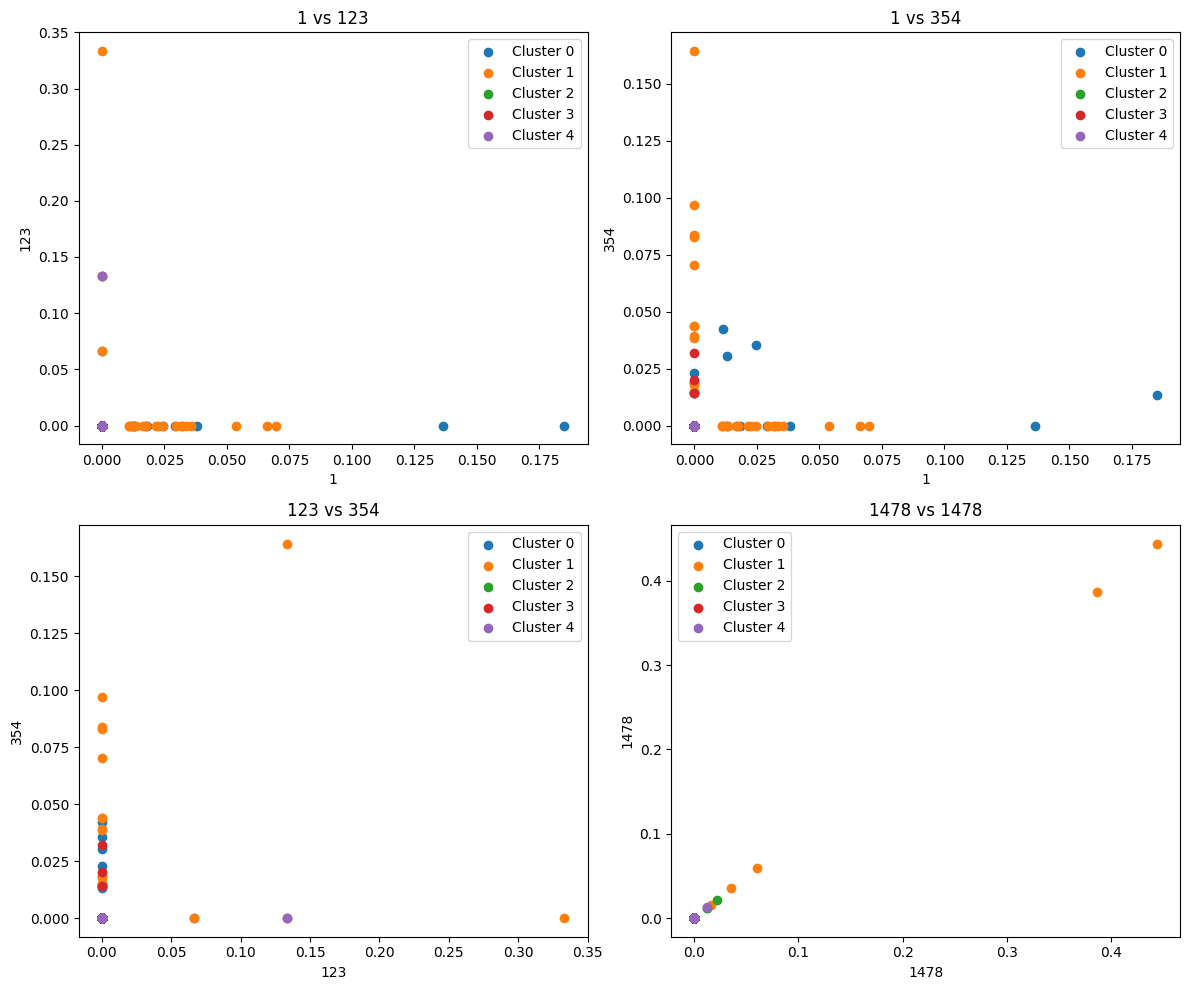

In [ ]:
import matplotlib.pyplot as plt

cols = [1, 123, 354, 1478]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, (x, y) in enumerate([(cols[0], cols[1]), (cols[0], cols[2]), (cols[1], cols[2]), (cols[3], cols[3])]):
    row = i // 2
    col = i % 2
    colors = plt.cm.get_cmap('tab10',n_clusters)

    for cluster in range(n_clusters):
        cluster_data = ratings[labels == cluster]
        axes[row, col].scatter(cluster_data[x], cluster_data[y], label=f'Cluster {cluster}')

    axes[row, col].set_title(f'{x} vs {y}')
    axes[row, col].set_xlabel(x)
    axes[row, col].set_ylabel(y)
    axes[row, col].legend()

plt.tight_layout()
plt.show()


**Ответ:** Визуализации плохо отражают, так как мы сильно понизили размерность данных

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

In [ ]:
from sklearn.manifold import TSNE

# -- YOUR CODE HERE --

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

# -- YOUR CODE HERE --

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Сделайте t-SNE визуализацию полученной кластеризации.

In [ ]:
# -- YOUR CODE HERE --

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --